# Time-warping with parametric stretch functions
*Nhat Le, November 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [3]:
# Sinc interpolation example
def interpol(t, x, intertype='sinc'):
    '''Given a signal x and a list of timestamps t
    Return the sinc interpolation at the timestamps'''
    if intertype == 'sinc':
        k = np.arange(len(x))
        tval, kval = np.meshgrid(t, k)
        ktmat = np.sinc(tval - kval)
        return np.dot(ktmat.T, x)
    elif intertype == 'linear':
        frac, floor = np.modf(t)
        floor_range = np.clip(t.astype('int'), 0, len(x) - 1)
        floor_next_range = np.clip((t + 1).astype('int'), 0, len(x) - 1)

        xfirst = x[floor_range]
        xnext = x[floor_next_range]

        return xfirst + frac * (xnext - xfirst)

def deriv_sinc(x):
    '''Derivative of the sinc function'''
    x[x == 0] = 10**-10
    return (x * np.cos(x) - np.sin(x)) / x**2

def total_cost(x, y, a, intertype='sinc'):
    '''Given x(t) and y(t), find ||x(at) - y(t)||**2'''
    N = min(int(len(x) / a), len(y))
    tvals = np.arange(N) * a
    x_stretch = interpol(tvals, x, intertype)
    
    return x_stretch[:N], np.sum((x_stretch[:N] - y[:N])**2) / N

def do_stretch(x, stretch, intertype='sinc'):
    '''Given: signal, x and stretch factor
    Returns array of t and x(t) stretched by that factor'''
    tvals = stretch * np.arange(int(len(x) / stretch))
    x_stretch = interpol(tvals, x, intertype)
    return tvals, x_stretch
    

In [4]:
def total_cost_new(x, y, a, intertype='sinc'):
    '''Given x(t) and y(t), find ||x(at) - y(t)||**2'''
    # Build a matrix for the transformation
    tbase = np.zeros((len(a), len(x) * 10))
    for i in range(len(a)):
        tbase[i,:] = np.arange(len(x) * 10)**i
    
    # Transform x's t values
    targs = np.dot(tbase.T, a)
    
    # Extract only the valid t values (those in the range [0,..,Tx - 1])
    valid_id = np.nonzero(np.all([targs >= 0, targs <= len(x) - 1], axis=0))[0]
    
    # Keep valid id's up to Ty
    valid_id = valid_id[valid_id < len(y)]
    
    tvalid = targs[valid_id]
    x_interp = interpol(tvalid, x, intertype)
    
    return valid_id, x_interp, np.sum((x_interp - y[valid_id])**2) / len(tvalid)

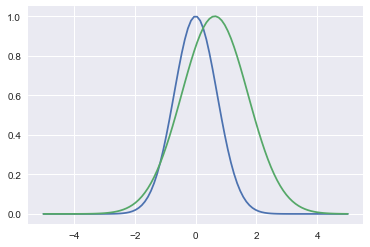

In [5]:
t = np.linspace(-5, 5, 100)
x = np.exp(-t**2)
y = np.exp(-(0.65 * t - 0.41)**2)
plt.plot(t,x)
plt.plot(t,y)

In [6]:
#x = np.array([0,2,4,2,0])
#y = np.array([0,1,2,3,4,5,4,3,2,1,0])
alst = np.linspace(0.1, 2, 50)

costold = []
costnew = []

for aval in alst:
    a_arr = np.array([0, aval])
    costold.append(total_cost(x, y, aval, 'sinc')[-1])
    costnew.append(total_cost_new(x, y, a_arr, 'sinc')[-1])
    

In [7]:
boptions = np.linspace(0, 30, 100)
aoptions = np.linspace(0.1, 1, 100)
res = np.zeros((100, 100))
for idb, b in enumerate(boptions):
    for ida, a in enumerate(aoptions):
        valid_id, x_stretch, cost = total_cost_new(x,y, np.array([b, a]), 'linear')
        res[idb][ida] = cost
        #plt.plot(t[valid_id], x_stretch)
        #plt.plot(t, x)

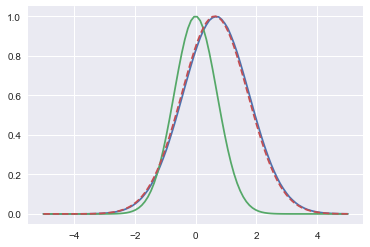

In [8]:
valid_id, x_stretch, cost = total_cost_new(x,y, np.array([13, 0.65]), 'linear')
plt.plot(t[valid_id], x_stretch)
plt.plot(t, x)
plt.plot(t, y, '--')

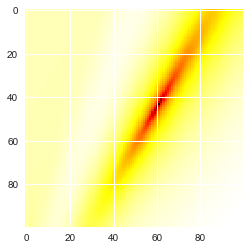

In [9]:
plt.imshow(np.log(res), cmap='hot')


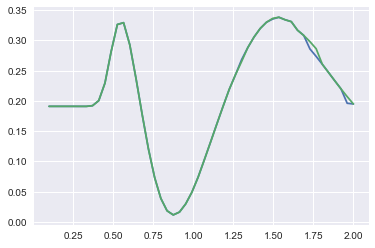

In [10]:
plt.plot(alst, costold)
plt.plot(alst, costnew)

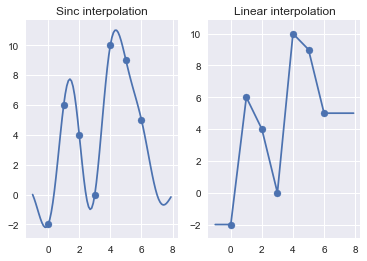

In [11]:
x = np.array([-2, 6,4,0,10, 9, 5])

t = np.arange(-1, 8, 0.1)
plt.subplot('121')
plt.plot(t, interpol(t, x, 'sinc'))
plt.scatter(range(len(x)), x)
plt.title('Sinc interpolation')

plt.subplot('122')
plt.plot(t, interpol(t, x, 'linear'))
plt.scatter(range(len(x)), x)
plt.title('Linear interpolation')

In [12]:
# Read in the neural data
short_psth = np.genfromtxt('./Raws/psth_short_all_neurons_nans_171102.csv', delimiter=',')
long_psth = np.genfromtxt('./Raws/psth_long_all_neurons_nans_171102.csv', delimiter=',')

t_points_short = 7
t_points_long = 9
n_neurons = 105
dt_bin = 40 #ms

# Reshape the short and long raw data into tensors
reshaped_short_psth = np.reshape(short_psth, (n_neurons, t_points_short, -1))
reshaped_long_psth = np.reshape(long_psth, (n_neurons, t_points_long, -1))
duration_short = reshaped_short_psth.shape[2]
duration_long = reshaped_long_psth.shape[2]

# Combine short and long trials into one tensor
reshaped_short_pad = np.lib.pad(reshaped_short_psth, ((0,0), (0,0), 
                                                      (0, duration_long-duration_short)), 
                                'constant', constant_values=(np.nan, np.nan))
reshaped_all_pad = np.concatenate((reshaped_short_pad, reshaped_long_psth), axis=1)

# Swap axes to feed in twpca
swapped_all = np.swapaxes(reshaped_all_pad, 0, 2)
swapped_all = np.swapaxes(swapped_all, 0, 1)

# Define palette used in plotting
palette_blue = sns.palettes.color_palette('Blues', t_points_short)
palette_red = sns.palettes.color_palette('Reds', t_points_long)

In [42]:
def get_stretch_neuron(all_neurons, neuron_id, stretches, intertype='sinc', normalize=True):
    '''Input: all_neurons: array of all neurons
    neuron_id: neuron of interest
    stretches: possible stretches to consider
    Returns the array of stretch for each condition'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] 
    if normalize:
        sref /= np.nanmedian(sref)
    
    min_stretch = []
    costs = []

    for i in range(all_neurons.shape[1]):
        s1 = all_neurons[neuron_id, i, :]
        s1 = s1[~np.isnan(s1)] 
        if normalize:
            s1 /= np.nanmedian(s1)
        cost = []
        for stretch in stretchlst:
            xs, cost_single = total_cost(s1, sref, stretch, intertype)
            cost.append(cost_single)
        costs.append(cost)
        min_stretch.append(stretchlst[np.argmin(cost)])
    return np.array(min_stretch)

def visualize_stretch(all_neurons, neuron_id, trial, stretch, intertype='sinc'):
    '''Given a neuronID and the stretch amount,
    plot the stretched trial'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmedian(sref)
    s1 = all_neurons[neuron_id, trial, :]
    s1 = s1[~np.isnan(s1)] / np.nanmedian(s1)
    _, x = do_stretch(s1, stretch, intertype)
    plt.plot(sref, '--', label='Reference')
    plt.plot(s1, label='Before')
    plt.plot(x, label='After')
    plt.legend()
    

In [15]:
def get_stretch_neuron_new(all_neurons, neuron_id, boptions, aoptions, intertype='sinc'):
    '''Input: all_neurons: array of all neurons
    neuron_id: neuron of interest
    stretches: possible stretches to consider
    Returns the array of stretch for each condition'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmax(sref)
    
    min_b_vals = []
    min_a_vals = []
    
    for i in range(all_neurons.shape[1]):
        print('Doing neuron #', i)
        s1 = all_neurons[neuron_id, i, :]
        s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
        bestcost = np.inf
        best_a = np.inf
        best_b = np.inf
        for ida, a in enumerate(aoptions):
            for idb, b in enumerate(boptions):
                _, _, cost = total_cost_new(s1, sref, np.array([b, a]), intertype)
                if cost < bestcost:
                    bestcost = cost
                    best_a = a
                    best_b = b
        
        min_a_vals.append(best_a)
        min_b_vals.append(best_b)
    return np.array([min_a_vals, min_b_vals])
    
    
def visualize_stretch_new(all_neurons, neuron_id, trial, a, intertype='sinc'):
    '''Given a neuronID and the stretch amount,
    plot the stretched trial'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmax(sref)
    s1 = all_neurons[neuron_id, trial, :]
    s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
    
    valid_id, x_stretch, cost = total_cost_new(s1, sref, a, 'linear')
    plt.plot(valid_id, x_stretch, label='After')
    plt.plot(s1, label='Before')
    plt.plot(sref, '--', label='Reference')
    plt.legend()
    

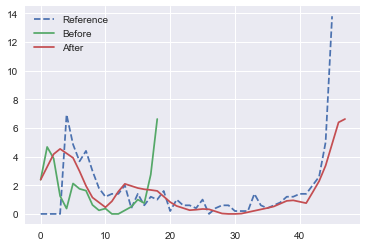

In [16]:
visualize_stretch(reshaped_all_pad, 0, 0, 0.39, 'linear')

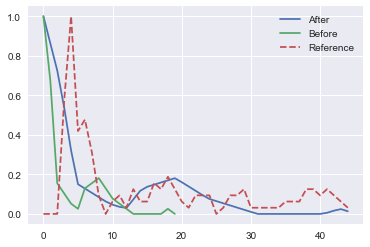

In [17]:
visualize_stretch_new(reshaped_all_pad, 10, 3, np.array([0, 0.42]), 'linear')

Stretch for single neuron

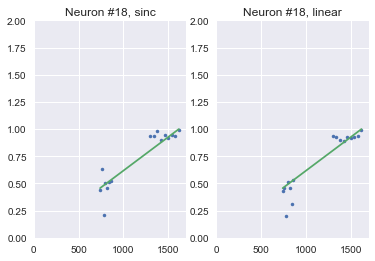

In [31]:
stretchlst = np.arange(0.1, 1.0, 0.01)
n_neuron = 18
min_stretch_sinc = get_stretch_neuron(reshaped_all_pad, n_neuron, stretchlst, 'sinc')
min_stretch_linear = get_stretch_neuron(reshaped_all_pad, n_neuron, stretchlst, 'linear')
times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])

plt.subplot('121')
plt.plot(times, min_stretch_sinc, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', sinc')

plt.subplot('122')
plt.plot(times, min_stretch_linear, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', linear')


## Find stretch for all neurons

In [43]:
stretchlst = np.arange(0.1, 1.0, 0.01)
times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
Min_stretch_sinc = np.zeros((n_neurons, len(times)))
Min_stretch_linear = np.zeros((n_neurons, len(times)))

for neuron_id in range(n_neurons):
    print('Aligning neuron #', neuron_id, ' of ', n_neurons)
    min_stretch_sinc = get_stretch_neuron(reshaped_all_pad, neuron_id, stretchlst, 'sinc')
    min_stretch_linear = get_stretch_neuron(reshaped_all_pad, neuron_id, stretchlst, 'linear')
    Min_stretch_sinc[neuron_id, :] = min_stretch_sinc
    Min_stretch_linear[neuron_id, :] = min_stretch_linear

Aligning neuron # 0  of  105
Aligning neuron # 1  of  105
Aligning neuron # 2  of  105
Aligning neuron # 3  of  105
Aligning neuron # 4  of  105
Aligning neuron # 5  of  105
Aligning neuron # 6  of  105
Aligning neuron # 7  of  105
Aligning neuron # 8  of  105
Aligning neuron # 9  of  105
Aligning neuron # 10  of  105
Aligning neuron # 11  of  105
Aligning neuron # 12  of  105
Aligning neuron # 13  of  105
Aligning neuron # 14  of  105
Aligning neuron # 15  of  105
Aligning neuron # 16  of  105
Aligning neuron # 17  of  105
Aligning neuron # 18  of  105
Aligning neuron # 19  of  105
Aligning neuron # 20  of  105
Aligning neuron # 21  of  105
Aligning neuron # 22  of  105
Aligning neuron # 23  of  105
Aligning neuron # 24  of  105
Aligning neuron # 25  of  105
Aligning neuron # 26  of  105
Aligning neuron # 27  of  105
Aligning neuron # 28  of  105
Aligning neuron # 29  of  105
Aligning neuron # 30  of  105
Aligning neuron # 31  of  105
Aligning neuron # 32  of  105
Aligning neuron # 33

C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in subtract


Aligning neuron # 42  of  105
Aligning neuron # 43  of  105
Aligning neuron # 44  of  105
Aligning neuron # 45  of  105
Aligning neuron # 46  of  105
Aligning neuron # 47  of  105
Aligning neuron # 48  of  105
Aligning neuron # 49  of  105
Aligning neuron # 50  of  105
Aligning neuron # 51  of  105
Aligning neuron # 52  of  105
Aligning neuron # 53  of  105
Aligning neuron # 54  of  105
Aligning neuron # 55  of  105
Aligning neuron # 56  of  105
Aligning neuron # 57  of  105
Aligning neuron # 58  of  105
Aligning neuron # 59  of  105
Aligning neuron # 60  of  105
Aligning neuron # 61  of  105
Aligning neuron # 62  of  105
Aligning neuron # 63  of  105
Aligning neuron # 64  of  105
Aligning neuron # 65  of  105
Aligning neuron # 66  of  105
Aligning neuron # 67  of  105
Aligning neuron # 68  of  105
Aligning neuron # 69  of  105
Aligning neuron # 70  of  105
Aligning neuron # 71  of  105
Aligning neuron # 72  of  105
Aligning neuron # 73  of  105
Aligning neuron # 74  of  105
Aligning n

Sinc and linear give similar results

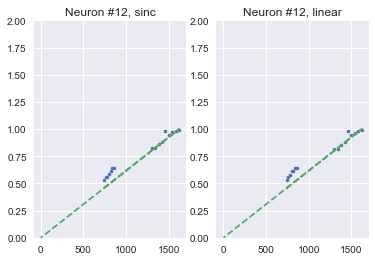

In [22]:
n_neuron = 12
times_zero = np.concatenate((times, [0]))

plt.subplot('121')
plt.plot(times, Min_stretch_sinc[n_neuron, :], '.')
#plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times_zero, times_zero / max(times), '--')
plt.title('Neuron #' + str(n_neuron) + ', sinc')

plt.subplot('122')
plt.plot(times, Min_stretch_linear[n_neuron, :], '.')
#plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times_zero, times_zero / max(times), '--')
plt.title('Neuron #' + str(n_neuron) + ', linear')

## Visualize neurons

In [ ]:
visualize_stretch(reshaped_all_pad, 31, 0, 0.44)

In [ ]:
visualize_stretch(reshaped_all_pad, 31, 0, 0.44)

In [ ]:
s, c = get_stretch_neuron(reshaped_all_pad, 17, stretchlst)

In [ ]:
plt.plot(s[7])

In [ ]:
Min_stretch_linear[31,:]

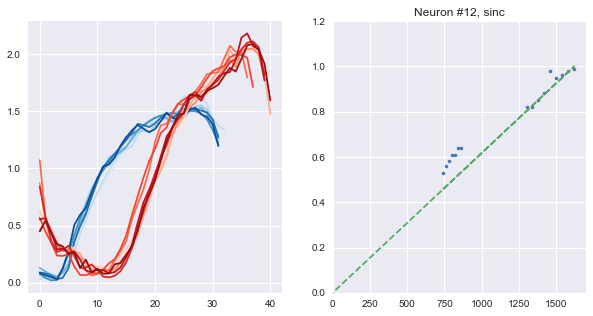

In [44]:
neuron_id = 12
sref = reshaped_all_pad[neuron_id, -1, :]
sref = sref[~np.isnan(sref)] / np.nanmean(sref)

plt.figure(figsize=(10, 5)) 
plt.subplot('121')
for trial in range(16):
    s1 = reshaped_all_pad[neuron_id, trial, :]
    s1 = s1[~np.isnan(s1)] / np.nanmean(s1)

    x_stretch, _ = total_cost(s1, sref, Min_stretch_linear[neuron_id, trial], 'linear')
    
    if trial < 7:
        plt.plot(x_stretch, label=str(trial), color=palette_blue[trial])
    else:
        plt.plot(x_stretch, label=str(trial), color=palette_red[trial - 7])

plt.subplot('122')
plt.plot(times, Min_stretch_linear[neuron_id, :], '.')
plt.xlim(0, 1700)
plt.ylim(0, 1.2)
plt.plot(times_zero, times_zero / max(times), '--')
plt.title('Neuron #' + str(neuron_id) + ', sinc')    

Now we find the correlation coefficient to quantify the goodness of fit.

Alternatively, we can also find the deviation from y = ax

In [52]:
corr_coefs = np.corrcoef(times, Min_stretch_linear)[0,1:]
filename_objs = './Processed_neurons/XACaudate/171113_caudate105_corr_coefs_linear_normmeandiv_global.csv'
if not os.path.isfile(filename_objs):
    np.savetxt(filename_objs, np.array(corr_coefs))
else:
    print('File exists!')

File exists!


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


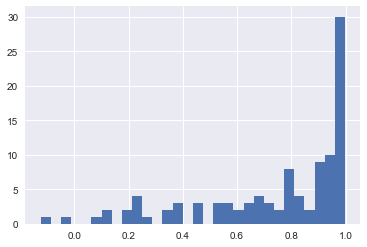

In [50]:
plt.hist(corr_coefs[~np.isnan(corr_coefs)], bins=30);

### Fitting with two parameters, scale and shift 

In [ ]:
aopts = np.arange(0.1, 1.0, 0.01)
bopts = np.arange(-5, 5)
n_neuron = 0
min_stretch_sinc = get_stretch_neuron_new(reshaped_all_pad, n_neuron, 
                                          boptions, aoptions, 'sinc')
#min_stretch_linear = get_stretch_neuron(reshaped_all_pad, n_neuron, stretchlst, 'linear')
times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])

In [ ]:
visualize_stretch_new(reshaped_all_pad, 0, 1, np.array([3.63, 0.309]), 'linear')

In [ ]:
s1 = reshaped_all_pad[0, 0, :]
sref = reshaped_all_pad[0, -1, :]
sref = sref[~np.isnan(sref)] / np.nanmax(sref)
s1 = s1[~np.isnan(s1)] / np.nanmax(s1)


plt.plot(s1)
plt.plot(sref)

In [ ]:
plt.subplot('121')
plt.plot(times, min_stretch_sinc, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', sinc')

plt.subplot('122')
plt.plot(times, min_stretch_linear, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', linear')

In [ ]:
ntimes = 15
neuron = 23
sref = reshaped_all_pad[neuron, -1, :]
sref = sref[~np.isnan(sref)] / np.nanmax(sref)
stretchlst = np.arange(0.1, 1.0, 0.001)

min_stretch = []
for i in range(16):
    s1 = reshaped_all_pad[neuron, i, :]
    s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
    cost = []
    for a in stretchlst:
        xs, cost_single = total_cost(s1, sref, a)
        cost.append(cost_single)
    min_stretch.append(stretchlst[np.argmin(cost)])
    #print(stretchlst[np.argmin(cost)])

times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
plt.plot(times, np.array(min_stretch), '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)